## Hybrid Attempt v3

>>> INIZIO PIPELINE OPZIONE B (Inflazione PCA + Tematico GT) <<<

--- Inizio Caricamento Dati ---
Dati caricati con successo per 'Termini_Diretti' da 'Gruppo1(4).csv'
Dati caricati con successo per 'Alimentari' da 'Gruppo2(4).csv'
Dati caricati con successo per 'Energia' da 'Gruppo3(4).csv'
Dati caricati con successo per 'Abitazione' da 'Gruppo4(4).csv'
Dati caricati con successo per 'Trasporti' da 'Gruppo5(4).csv'
Dati caricati con successo per 'Politiche_Economiche' da 'Gruppo6(4).csv'
Dati caricati con successo per 'Aspettative_Consumatori' da 'Gruppo7(4).csv'
Dati caricati con successo per 'Sanita' da 'Gruppo8(4).csv'
Dati caricati con successo per 'Ricreazione' da 'Gruppo9(4).csv'
--- Fine Caricamento Dati ---

--- Inizio Identificazione Periodo Comune ---
Info (Periodo Comune): Da 2004-01-01 a 2024-12-01
--- Fine Identificazione Periodo Comune ---

--- Inizio Combinazione Dati ---
Info (Combinazione): DF combinato 252r x 45c.
--- Fine Combinazione Dati ---

--- Inizio Pulizia Val

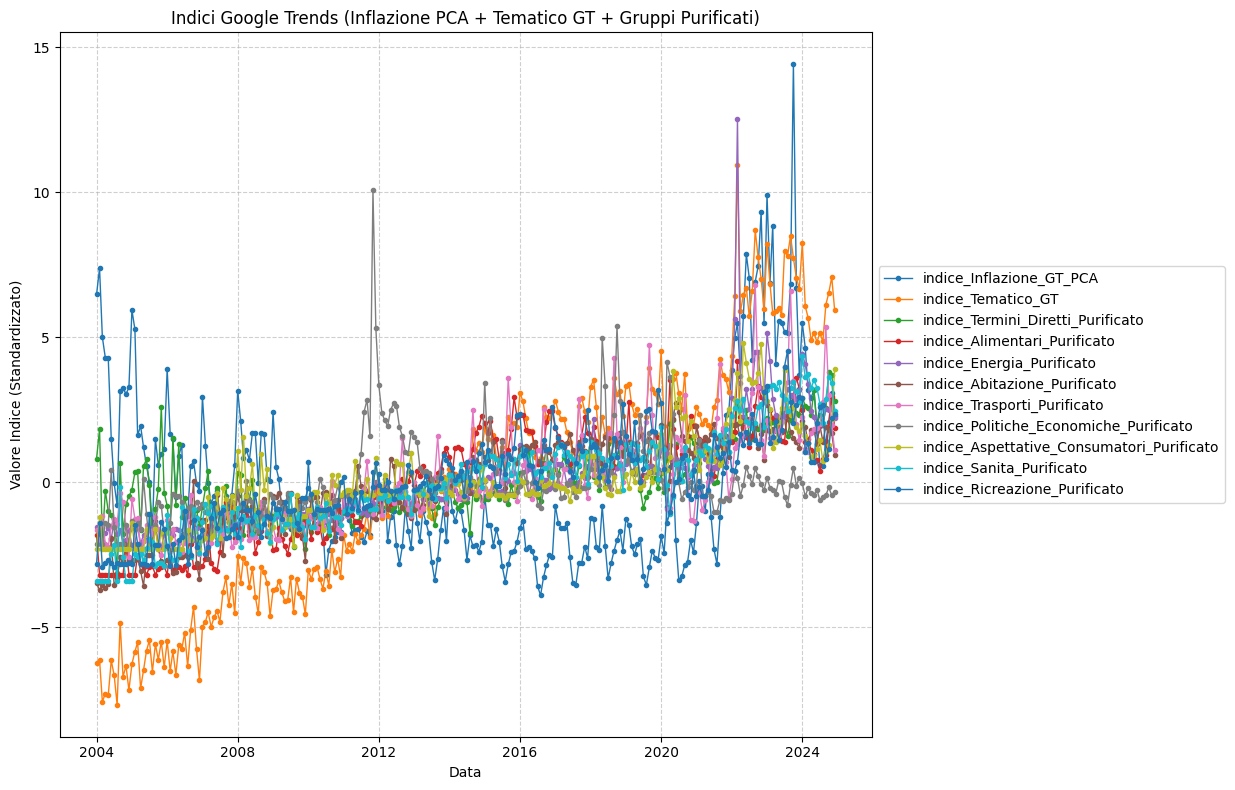

Info: Indici salvati in '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v3.csv'
--- Fine Visualizzazione e Salvataggio Indici ---


>>> PIPELINE OPZIONE B COMPLETATA <<<


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- CONFIGURAZIONE ---
PATH_DATI = "/Users/tommaso/Desktop/tesi-inflation-gt/Official_4" 
PATH_SALVATAGGIO_INDICI = '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v3.csv'

NOMI_GRUPPI_DICT = {
    "Gruppo1(4)": "Termini_Diretti",
    "Gruppo2(4)": "Alimentari",
    "Gruppo3(4)": "Energia",
    "Gruppo4(4)": "Abitazione",
    "Gruppo5(4)": "Trasporti",
    "Gruppo6(4)": "Politiche_Economiche",
    "Gruppo7(4)": "Aspettative_Consumatori",
    "Gruppo8(4)": "Sanita",
    "Gruppo9(4)": "Ricreazione"
}
# Parola chiave per identificare le colonne relative all'inflazione diretta
INFLATION_KEYWORD_IN_COLNAME = "inflazione"

# --- 1. CARICAMENTO DATI ---
def carica_dati_gt(path_csv, nomi_file_mappati):
    dati_caricati_per_gruppo = {}
    print("--- Inizio Caricamento Dati ---")
    for nome_file_csv, nome_gruppo_logico in nomi_file_mappati.items():
        file_path = os.path.join(path_csv, f"{nome_file_csv}.csv")
        try:
            df = pd.read_csv(file_path, skiprows=2, header=0)
            df.columns = [str(col).strip().lower() for col in df.columns]
            colonna_data = None
            for possible_date_col in ['mese', 'month', 'settimana', 'week', 'giorno', 'day']:
                if possible_date_col in df.columns:
                    colonna_data = possible_date_col
                    break
            if colonna_data is None: raise ValueError(f"Nessuna colonna data standard trovata in {nome_file_csv}")
            if colonna_data != 'mese': print(f"Info: Trovata colonna data '{colonna_data}' in {nome_file_csv}.")
            df.set_index(colonna_data, inplace=True)
            try: df.index = pd.to_datetime(df.index)
            except Exception: df.index = pd.to_datetime(df.index, format="%Y-%m")
            dati_caricati_per_gruppo[nome_gruppo_logico] = df
            print(f"Dati caricati con successo per '{nome_gruppo_logico}' da '{nome_file_csv}.csv'")
        except Exception as e: print(f"ERRORE nel caricamento di '{nome_file_csv}.csv': {e}")
    print("--- Fine Caricamento Dati ---\n")
    return dati_caricati_per_gruppo

# --- 2. IDENTIFICAZIONE PERIODO COMUNE ---
def trova_periodo_comune(dati_dict_input):
    print("--- Inizio Identificazione Periodo Comune ---")
    if not dati_dict_input: return None, None
    date_inizio_valide, date_fine_valide = [], []
    for df in dati_dict_input.values():
        if not df.empty and isinstance(df.index, pd.DatetimeIndex):
            date_inizio_valide.append(df.index.min()); date_fine_valide.append(df.index.max())
    if not date_inizio_valide: return None, None
    inizio_comune_calc, fine_comune_calc = max(date_inizio_valide), min(date_fine_valide)
    if inizio_comune_calc > fine_comune_calc: print(f"Attenzione: Nessun periodo comune valido."); return None, None
    print(f"Info (Periodo Comune): Da {inizio_comune_calc.strftime('%Y-%m-%d')} a {fine_comune_calc.strftime('%Y-%m-%d')}")
    print("--- Fine Identificazione Periodo Comune ---\n")
    return inizio_comune_calc, fine_comune_calc

# --- 3. COMBINAZIONE DATI SU PERIODO COMUNE ---
def combina_dati_su_periodo_comune(dati_dict_input, inizio_dt, fine_dt):
    print("--- Inizio Combinazione Dati ---")
    if inizio_dt is None or fine_dt is None or not dati_dict_input: return None
    idx_comune = pd.date_range(start=inizio_dt, end=fine_dt, freq='MS')
    df_combinato_finale = pd.DataFrame(index=idx_comune)
    for nome_gruppo_logico, df_originale in dati_dict_input.items():
        if df_originale.empty or not isinstance(df_originale.index, pd.DatetimeIndex): continue
        df_periodo_gruppo = df_originale[(df_originale.index >= inizio_dt) & (df_originale.index <= fine_dt)]
        if df_periodo_gruppo.empty: continue
        for col_originale_nome in df_periodo_gruppo.columns:
            nome_colonna_con_prefisso = f"{nome_gruppo_logico}_{col_originale_nome}"
            df_combinato_finale[nome_colonna_con_prefisso] = df_periodo_gruppo[col_originale_nome].reindex(df_combinato_finale.index)
    print(f"Info (Combinazione): DF combinato {df_combinato_finale.shape[0]}r x {df_combinato_finale.shape[1]}c.")
    print("--- Fine Combinazione Dati ---\n")
    return df_combinato_finale

# --- 4. PULIZIA VALORI GOOGLE TRENDS ('<1') ---
def pulisci_valori_gt(df_input):
    print("--- Inizio Pulizia Valori Google Trends ('<1') ---")
    if df_input is None: return None
    df_pulito = df_input.copy()
    for col in df_pulito.columns:
        col_as_str = df_pulito[col].astype(str)
        if col_as_str.str.contains(r'< ?1').any():
            df_pulito[col] = df_pulito[col].replace(to_replace=r'< ?1', value=0.5, regex=True)
        df_pulito[col] = pd.to_numeric(df_pulito[col], errors='coerce')
    print("--- Fine Pulizia Valori Google Trends --- \n")
    return df_pulito

# --- 5. GESTIONE VALORI MANCANTI (NaN) ---
def gestisci_nan(df_input, strategy='fillna', fill_value=0, interpolate_method='linear'):
    print(f"--- Inizio Gestione NaN (Strategia: {strategy}) ---")
    if df_input is None: return None
    df_gestito = df_input.copy()
    if not df_gestito.isnull().values.any(): print("Info: Nessun NaN trovato."); return df_gestito
    if strategy == 'fillna': df_gestito = df_gestito.fillna(fill_value)
    elif strategy == 'interpolate':
        df_gestito = df_gestito.interpolate(method=interpolate_method, axis=0)
        if df_gestito.isnull().values.any(): df_gestito = df_gestito.fillna(fill_value)
    print("Info: NaN gestiti.")
    print("--- Fine Gestione NaN ---\n")
    return df_gestito

# --- 6. STANDARDIZZAZIONE SERIE (Z-SCORE) ---
def standardizza_serie_temporali(df_input):
    print("--- Inizio Standardizzazione Serie (Z-score) ---")
    if df_input is None: return None
    df_std = df_input.copy()
    for col in df_std.columns:
        if not pd.api.types.is_numeric_dtype(df_std[col]): continue
        media, std_dev = df_std[col].mean(), df_std[col].std()
        df_std[col] = (df_std[col] - media) / std_dev if std_dev > 1e-9 else 0 # Evita divisione per zero per std_dev molto piccoli
    print("--- Fine Standardizzazione Serie ---\n")
    return df_std

# --- 7. CREAZIONE INDICE INFLAZIONE TRAMITE PCA E SEPARAZIONE TERMINI ---
def crea_indice_inflazione_pca_e_separa_termini(df_std_input, inflation_keyword):
    print(f"--- Inizio Creazione Indice Inflazione PCA (keyword: '{inflation_keyword}') ---")
    if df_std_input is None or df_std_input.empty: return pd.Series(dtype=float), df_std_input

    colonne_inflazione = [col for col in df_std_input.columns if inflation_keyword.lower() in col.lower()]
    indice_inflazione_pca_series = pd.Series(index=df_std_input.index, dtype=float)
    df_senza_termini_inflazione = df_std_input.copy()

    if not colonne_inflazione:
        print(f"Attenzione: Nessun termine '{inflation_keyword}' trovato.")
    else:
        df_termini_inflazione_validi = df_std_input[colonne_inflazione].loc[:, df_std_input[colonne_inflazione].var(skipna=True) > 1e-9] # skipna aggiunto
        if df_termini_inflazione_validi.empty:
            print(f"Attenzione: Nessun termine '{inflation_keyword}' con varianza sufficiente.")
        elif df_termini_inflazione_validi.shape[1] == 1:
            indice_inflazione_pca_series = df_termini_inflazione_validi.iloc[:, 0]
            print(f"Info: Usata singola colonna valida per Indice Inflazione: {df_termini_inflazione_validi.columns[0]}")
        else:
            pca_infl = PCA(n_components=1)
            try:
                if df_termini_inflazione_validi.isnull().values.any(): raise ValueError("NaN in PCA data for inflation index.")
                componente_infl = pca_infl.fit_transform(df_termini_inflazione_validi)
                indice_inflazione_pca_series = pd.Series(componente_infl.flatten(), index=df_termini_inflazione_validi.index)
                print(f"Info: Indice Inflazione PCA creato da {df_termini_inflazione_validi.shape[1]} termini. Var. Spiegata: {pca_infl.explained_variance_ratio_[0]:.2%}")
                print("  Loadings su Indice Inflazione PCA:"); [print(f"    {n}: {l:.4f}") for n,l in zip(df_termini_inflazione_validi.columns, pca_infl.components_[0])]
            except Exception as e: print(f"ERRORE PCA Indice Inflazione: {e}")
        df_senza_termini_inflazione = df_std_input.drop(columns=colonne_inflazione, errors='ignore')
        print(f"Info: Rimossi termini '{inflation_keyword}'. Rimanenti {df_senza_termini_inflazione.shape[1]} colonne per PCA di gruppo.")
    print("--- Fine Creazione Indice Inflazione PCA ---\n")
    return indice_inflazione_pca_series, df_senza_termini_inflazione

# --- 8. CREAZIONE INDICI PCA PER GRUPPO (SENZA TERMINI INFLAZIONE) ---
def crea_indici_pca_per_gruppo_purificati(df_input_senza_infl, nomi_gruppi_mappati):
    print("--- Inizio Creazione Indici PCA per Gruppo (Purificati) ---")
    if df_input_senza_infl is None or df_input_senza_infl.empty: return pd.DataFrame(index=df_input_senza_infl.index if df_input_senza_infl is not None else None)
    indici_pca_df = pd.DataFrame(index=df_input_senza_infl.index)
    for nome_gruppo_logico in nomi_gruppi_mappati.values():
        colonne_del_gruppo = [col for col in df_input_senza_infl.columns if col.startswith(f"{nome_gruppo_logico}_")]
        if not colonne_del_gruppo: indici_pca_df[f'indice_{nome_gruppo_logico}_Purificato'] = np.nan; continue
        dati_gruppo_pca_validi = df_input_senza_infl[colonne_del_gruppo].loc[:, df_input_senza_infl[colonne_del_gruppo].var(skipna=True) > 1e-9]
        if dati_gruppo_pca_validi.shape[1] >= 1:
            if dati_gruppo_pca_validi.shape[1] == 1:
                indici_pca_df[f'indice_{nome_gruppo_logico}_Purificato'] = dati_gruppo_pca_validi.iloc[:, 0]
            else:
                pca = PCA(n_components=1)
                try:
                    if dati_gruppo_pca_validi.isnull().values.any(): raise ValueError("NaN in group PCA data.")
                    componente = pca.fit_transform(dati_gruppo_pca_validi)
                    indici_pca_df[f'indice_{nome_gruppo_logico}_Purificato'] = componente.flatten()
                    print(f"\nGruppo '{nome_gruppo_logico}' (Purificato): Var: {pca.explained_variance_ratio_[0]:.2%} ({dati_gruppo_pca_validi.shape[1]} vars)")
                    # print("  Loadings:"); [print(f"    {n}: {l:.4f}") for n,l in zip(dati_gruppo_pca_validi.columns, pca.components_[0])]
                except Exception as e: print(f"ERRORE PCA grp '{nome_gruppo_logico}': {e}"); indici_pca_df[f'indice_{nome_gruppo_logico}_Purificato'] = np.nan
        else: indici_pca_df[f'indice_{nome_gruppo_logico}_Purificato'] = np.nan
    print("--- Fine Creazione Indici PCA per Gruppo (Purificati) ---\n")
    return indici_pca_df

# --- 9. CREAZIONE INDICE TEMATICO GT (PCA SU INDICI DI GRUPPO PURIFICATI) ---
def crea_indice_tematico_gt(df_indici_gruppo_puri_input):
    print("--- Inizio Creazione Indice Tematico GT ---")
    if df_indici_gruppo_puri_input is None or df_indici_gruppo_puri_input.empty:
        print("Errore: DataFrame indici di gruppo purificati è None o vuoto.")
        return pd.Series(dtype=float, index=df_indici_gruppo_puri_input.index if df_indici_gruppo_puri_input is not None else None)

    df_per_pca_tematica = df_indici_gruppo_puri_input.dropna(axis=0, how='any') # Rimuove righe con NaN per PCA
    if df_per_pca_tematica.empty:
        print("Attenzione: Nessuna riga dopo rimozione NaN dagli indici di gruppo. Indice Tematico non creato.")
        return pd.Series(index=df_indici_gruppo_puri_input.index, dtype=float)

    indici_tematici_validi = df_per_pca_tematica.loc[:, df_per_pca_tematica.var(skipna=True) > 1e-9]
    serie_indice_tematico_gt = pd.Series(index=df_indici_gruppo_puri_input.index, dtype=float) # Per output finale

    if indici_tematici_validi.shape[1] >= 1:
        if indici_tematici_validi.shape[1] == 1:
            print(f"Info: Un solo indice di gruppo purificato valido ('{indici_tematici_validi.columns[0]}'). Usato come Indice Tematico GT.")
            # Allinea all'indice originale del df_indici_gruppo_puri_input per correttezza
            serie_indice_tematico_gt = indici_tematici_validi.iloc[:,0].reindex(df_indici_gruppo_puri_input.index)
        else:
            pca_tematico = PCA(n_components=1)
            try:
                componente_tematico = pca_tematico.fit_transform(indici_tematici_validi)
                # Crea serie con indice corretto e poi assegna/reindexa
                temp_serie = pd.Series(componente_tematico.flatten(), index=indici_tematici_validi.index)
                serie_indice_tematico_gt = temp_serie.reindex(df_indici_gruppo_puri_input.index)

                print(f"\nIndice Tematico GT: Var. Spiegata: {pca_tematico.explained_variance_ratio_[0]:.2%} (su {indici_tematici_validi.shape[1]} indici di gruppo purificati)")
                print("  Loadings sull'Indice Tematico GT:"); [print(f"    {n}: {l:.4f}") for n,l in zip(indici_tematici_validi.columns, pca_tematico.components_[0])]
            except Exception as e: print(f"ERRORE PCA Indice Tematico: {e}")
    else:
        print("Info: Nessun indice di gruppo purificato con varianza sufficiente per Indice Tematico GT.")
    print("--- Fine Creazione Indice Tematico GT ---\n")
    return serie_indice_tematico_gt

# --- 10. VISUALIZZAZIONE E SALVATAGGIO ---
def visualizza_e_salva_indici(df_indici_da_salvare, path_salvataggio_csv, titolo_grafico):
    print("--- Inizio Visualizzazione e Salvataggio Indici ---")
    if df_indici_da_salvare is None or df_indici_da_salvare.empty: return
    
    # Prepara un DataFrame per il plotting, assicurandoti che solo le serie principali siano plottate se troppe
    df_to_plot = df_indici_da_salvare.copy()
    colonne_principali = [col for col in ['indice_Inflazione_GT_PCA', 'indice_Tematico_GT'] if col in df_to_plot.columns]
    
    # Se ci sono troppe colonne (es. più di 5 oltre alle principali), considera di plottare solo le principali
    # o fare plot separati. Per ora, plottiamo tutto ciò che è numerico.
    df_numeric_to_plot = df_to_plot.select_dtypes(include=np.number)

    if not df_numeric_to_plot.empty:
        plt.figure(figsize=(15, 8))
        for col_nome in df_numeric_to_plot.columns:
            if not df_numeric_to_plot[col_nome].isnull().all():
                 plt.plot(df_numeric_to_plot.index, df_numeric_to_plot[col_nome], label=col_nome, marker='.', linestyle='-', linewidth=1)
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles: plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(titolo_grafico)
        plt.xlabel('Data'); plt.ylabel('Valore Indice (Standardizzato)')
        plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(rect=[0, 0, 0.83, 1]); plt.show()
    try:
        os.makedirs(os.path.dirname(path_salvataggio_csv), exist_ok=True)
        df_indici_da_salvare.to_csv(path_salvataggio_csv, index=True)
        print(f"Info: Indici salvati in '{path_salvataggio_csv}'")
    except Exception as e: print(f"ERRORE salvataggio: {e}")
    print("--- Fine Visualizzazione e Salvataggio Indici ---\n")

# --- ESECUZIONE PIPELINE (OPZIONE B) ---
if __name__ == "__main__":
    print(">>> INIZIO PIPELINE OPZIONE B (Inflazione PCA + Tematico GT) <<<\n")

    # 1. Caricamento
    dati_caricati = carica_dati_gt(PATH_DATI, NOMI_GRUPPI_DICT)

    # 2. Periodo Comune
    start_date, end_date = trova_periodo_comune(dati_caricati)

    # 3. Combinazione Dati
    df_combinato = combina_dati_su_periodo_comune(dati_caricati, start_date, end_date)

    # 4. Pulizia Valori GT
    df_pulito_gt = pulisci_valori_gt(df_combinato)

    # 5. Gestione NaN
    df_senza_nan = gestisci_nan(df_pulito_gt, strategy='fillna', fill_value=0)
    # Alternativa: df_senza_nan = gestisci_nan(df_pulito_gt, strategy='interpolate')


    # 6. Standardizzazione
    df_standardizzato = standardizza_serie_temporali(df_senza_nan)

    # 7. Creazione Indice Inflazione tramite PCA e Separazione Termini
    serie_inflazione_pca, df_std_senza_termini_infl = crea_indice_inflazione_pca_e_separa_termini(
        df_standardizzato,
        INFLATION_KEYWORD_IN_COLNAME
    )

    # 8. Creazione Indici PCA per Gruppo "Purificati" (sui termini rimanenti)
    df_indici_gruppo_purificati = crea_indici_pca_per_gruppo_purificati(
        df_std_senza_termini_infl,
        NOMI_GRUPPI_DICT
    )

    # 9. Creazione Indice Tematico GT (PCA sugli indici di gruppo purificati)
    serie_indice_tematico_gt = crea_indice_tematico_gt(df_indici_gruppo_purificati)
    
    # 10. Assemblaggio DataFrame Finale per output e analisi
    df_output_finale = pd.DataFrame(index=df_standardizzato.index) # Usa un indice comune e completo
    df_output_finale['indice_Inflazione_GT_PCA'] = serie_inflazione_pca.reindex(df_output_finale.index)
    df_output_finale['indice_Tematico_GT'] = serie_indice_tematico_gt.reindex(df_output_finale.index)
    
    # Aggiungi anche gli indici di gruppo purificati se desideri analizzarli/salvarli individualmente
    for col in df_indici_gruppo_purificati.columns:
        df_output_finale[col] = df_indici_gruppo_purificati[col].reindex(df_output_finale.index)
        
    # Rimuovi eventuali colonne che sono interamente NaN (se qualche indice non è stato creato)
    df_output_finale.dropna(axis=1, how='all', inplace=True)


    # 11. Visualizzazione e Salvataggio
    visualizza_e_salva_indici(
        df_output_finale,
        PATH_SALVATAGGIO_INDICI,
        'Indici Google Trends (Inflazione PCA + Tematico GT + Gruppi Purificati)'
    )

    print("\n>>> PIPELINE OPZIONE B COMPLETATA <<<")
